## Figure 4

Percent matching for Cell Painting and L1000

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggrepel))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure4_percentmatching")
extensions <- c(".png", ".pdf")

### Panel A - Percent matching within assay

In [3]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

# To add analysis facet of all dose percent matching
updated_dose_order <- c(dose_order, "All*", "All")

In [4]:
pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir, append_all_dose = TRUE)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir, append_all_dose = TRUE)

print(dim(pm_cellpainting_list[["percent_matching"]]))
print(dim(pm_l1000_list[["percent_matching"]]))

print(dim(pm_cellpainting_list[["percent_matching_pvals"]]))
print(dim(pm_l1000_list[["percent_matching_pvals"]]))

[1] 1477    5
[1] 1477    5
[1] 1477    5
[1] 1477    5


In [5]:
p_val_alpha_thresh <- 0.05
plot_thresh <- -log10(p_val_alpha_thresh)

no_replicates_thresh <- 3

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

# Append a new set of results for All dose
# when you only consider the common MOAs in the dose-specific results
dose_specific_moa_class <- unique(
    pm_df %>%
        dplyr::filter(dose == "0.04 uM") %>%
        dplyr::pull(moa)
    )

print(length(dose_specific_moa_class))

pm_all_dose_df <- pm_df %>%
    dplyr::filter(dose == "All") %>%
    dplyr::filter(moa %in% !!dose_specific_moa_class)

pm_all_dose_df$dose <- "All*"

# Add back to pm_df
pm_df <- dplyr::bind_rows(pm_df, pm_all_dose_df)

pm_df$dose <- factor(pm_df$dose, levels = updated_dose_order)

# Output percent matching (MOA)
output_file <- file.path("results", "moa_scores.tsv")
readr::write_tsv(pm_df, output_file)

print(dim(pm_df))
head(pm_df)

[1] 127
[1] 2200    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,0.004444607,Cell Painting,0.513,FALSE,0.2898826
acetylcholine receptor agonist,8,0.04 uM,0.005142343,Cell Painting,0.576,FALSE,0.2395775
acetylcholine receptor antagonist,21,0.04 uM,0.019262183,Cell Painting,0.017,TRUE,1.7695511
adenosine receptor agonist,3,0.04 uM,0.009583710,Cell Painting,0.442,FALSE,0.3545777
adenosine receptor antagonist,4,0.04 uM,0.001703919,Cell Painting,0.612,FALSE,0.2132486
adrenergic receptor agonist,20,0.04 uM,0.005015938,Cell Painting,0.683,FALSE,0.1655793


In [6]:
table(pm_df$no_of_replicates, pm_df$assay)

     
      Cell Painting L1000
  3             258   258
  4             162   162
  5              84    84
  6              65    60
  7              60    60
  8              24    24
  9              12    12
  11             12    12
  12             97    96
  13             12    12
  14             12    12
  15             12    12
  18             82    86
  19              6     6
  20              6     6
  21              6     6
  24             64    60
  27              6     6
  28              6     6
  30             32    28
  31              6     6
  36             14    20
  42             16    20
  48              8     8
  54              4     4
  60              2     0
  66              2     4
  72              6     4
  78              2     4
  84              4     4
  90              4     4
  108             2     0
  114             0     2
  120             4     2
  126             0     2
  138             2     0
  144             0     2
  150 

In [7]:
percent_matching_df <- pm_df %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::mutate(percent_matching = paste0(100 * round((sum(pass_thresh) / length(pass_thresh)), 2), "%")) %>%
    dplyr::select(dose, assay, percent_matching) %>%
    dplyr::distinct()

percent_matching_df

dose,assay,percent_matching
<fct>,<chr>,<chr>
0.04 uM,Cell Painting,16%
0.12 uM,Cell Painting,17%
0.37 uM,Cell Painting,20%
1.11 uM,Cell Painting,23%
3.33 uM,Cell Painting,28%
10 uM,Cell Painting,28%
All,Cell Painting,44%
0.04 uM,L1000,7%
0.12 uM,L1000,10%


In [8]:
# How many compounds per assay per dose with greater than 3 compounds?
for (dose in unique(pm_df$dose)) {
    print(dose)
    pm_sub_df <- pm_df %>% dplyr::filter(dose == !!dose)
    print(table(pm_sub_df %>% dplyr::pull(assay)))
}

[1] "0.04 uM"

Cell Painting         L1000 
          127           127 
[1] "0.12 uM"

Cell Painting         L1000 
          127           127 
[1] "0.37 uM"

Cell Painting         L1000 
          127           127 
[1] "1.11 uM"

Cell Painting         L1000 
          127           127 
[1] "3.33 uM"

Cell Painting         L1000 
          127           127 
[1] "10 uM"

Cell Painting         L1000 
          127           127 
[1] "All"

Cell Painting         L1000 
          211           211 
[1] "All*"

Cell Painting         L1000 
          127           127 


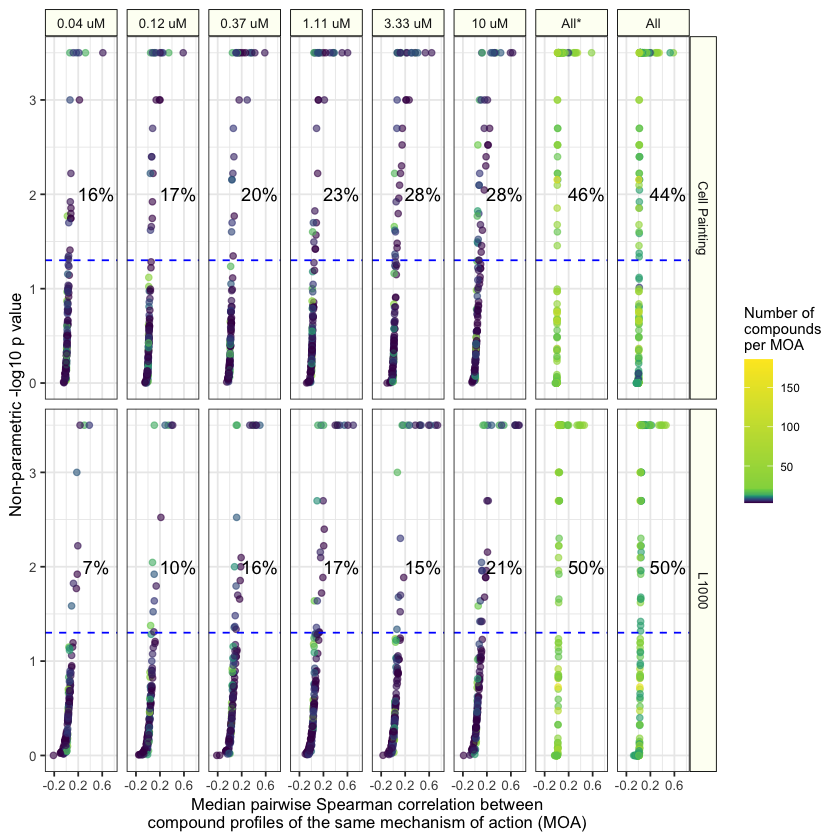

In [9]:
panel_a_gg <- (
    ggplot(pm_df, aes(x = matching_score, y = neg_log_10_p_val))
    + geom_point(aes(color = no_of_replicates), alpha = 0.6)
    + geom_text(data = percent_matching_df, aes(label = percent_matching, x = 0.5, y = 2))
    + facet_grid("assay~dose")
    + geom_hline(linetype = "dashed", color = "blue", yintercept = plot_thresh)
    + theme_bw()
    + figure_theme
    + scale_color_continuous("Number of\ncompounds\nper MOA", values = scales::rescale(c(0, 2, 4, 6, 8, 15, 150)), type = "viridis")
    + xlab("Median pairwise Spearman correlation between\ncompound profiles of the same mechanism of action (MOA)")
    + ylab("Non-parametric -log10 p value")
    + scale_x_continuous(breaks = seq(-0.2, 0.8, 0.4), limits = c(-0.3, 0.8))
)

panel_a_gg

## Panel B - MOA median correlation comparison between assays

In [10]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir, append_all_dose = TRUE)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir, append_all_dose = TRUE)

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

# Append a new set of results for All dose
# when you only consider the common MOAs in the dose-specific results
dose_specific_moa_class <- unique(
    pm_df %>%
        dplyr::filter(dose == "0.04 uM") %>%
        dplyr::pull(moa)
    )

print(length(dose_specific_moa_class))

pm_all_dose_df <- pm_df %>%
    dplyr::filter(dose == "All") %>%
    dplyr::filter(moa %in% !!dose_specific_moa_class)

pm_all_dose_df$dose <- "All*"

# Add back to pm_df
pm_df <- dplyr::bind_rows(pm_df, pm_all_dose_df)

pm_df$dose <- factor(pm_df$dose, levels = updated_dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

print(dim(pm_df))
head(pm_df)

[1] 127
[1] 2200    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,0.004444607,Cell Painting,0.513,FALSE,0.2898826
acetylcholine receptor agonist,8,0.04 uM,0.005142343,Cell Painting,0.576,FALSE,0.2395775
acetylcholine receptor antagonist,21,0.04 uM,0.019262183,Cell Painting,0.017,TRUE,1.7695511
adenosine receptor agonist,3,0.04 uM,0.009583710,Cell Painting,0.442,FALSE,0.3545777
adenosine receptor antagonist,4,0.04 uM,0.001703919,Cell Painting,0.612,FALSE,0.2132486
adrenergic receptor agonist,20,0.04 uM,0.005015938,Cell Painting,0.683,FALSE,0.1655793


In [11]:
# Prep additional data for plotting
replicate_counts_df <- pm_df %>%
    tidyr::drop_na() %>%
    dplyr::group_by(moa, dose) %>%
    dplyr::mutate(avg_replicate_count = mean(no_of_replicates)) %>%
    dplyr::select(moa, dose, avg_replicate_count) %>%
    dplyr::ungroup() %>%
    dplyr::distinct()

cp_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "Cell Painting", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_cellpainting = pass_thresh)

l1000_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "L1000", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_l1000 = pass_thresh)

pass_thresh_both <- cp_pass_thresh %>%
    dplyr::full_join(l1000_pass_thresh, by = c("moa", "dose")) %>%
    tidyr::replace_na(list(pass_thresh_cellpainting = FALSE, pass_thresh_l1000 = FALSE)) %>%
    dplyr::mutate(pass_both = pass_thresh_cellpainting + pass_thresh_l1000) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::mutate(moa_color_passing = 0)

pass_thresh_both$moa_color_passing[pass_thresh_both$pass_both] <- "#DF74F0"
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_cellpainting & !pass_thresh_both$pass_both)] <- paste(assay_colors["Cell Painting"])
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_l1000 & !pass_thresh_both$pass_both)] <- assay_colors["L1000"]

head(pass_thresh_both)

moa,dose,pass_thresh_cellpainting,pass_thresh_l1000,pass_both,moa_color_passing
<chr>,<fct>,<lgl>,<lgl>,<lgl>,<chr>
acetylcholine receptor antagonist,0.04 uM,TRUE,FALSE,FALSE,#F0C178
androgen receptor agonist,0.04 uM,TRUE,FALSE,FALSE,#F0C178
aromatase inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178
benzodiazepine receptor agonist,0.04 uM,TRUE,FALSE,FALSE,#F0C178
cdk inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178
dipeptidyl peptidase inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178


In [12]:
plot_ready_pm_df <- pm_df %>%
    reshape2::dcast(moa + dose ~ assay, value.var = "matching_score") %>%
    tidyr::drop_na() %>%
    dplyr::left_join(replicate_counts_df, by = c("moa", "dose")) %>%
    dplyr::left_join(pass_thresh_both, by = c("moa", "dose")) %>%
    tidyr::replace_na(
        list(
            pass_thresh_cellpainting = FALSE,
            pass_thresh_l1000 = FALSE,
            pass_both = FALSE,
            moa_color_passing = "lightgrey"
        )
    )

# Output file for further use
output_pm_file <- file.path("data", "significant_moas_by_threshold_both_assays.tsv.gz")
plot_ready_pm_df %>% readr::write_tsv(output_pm_file)

head(plot_ready_pm_df)

,moa,dose,Cell Painting,L1000,avg_replicate_count,pass_thresh_cellpainting,pass_thresh_l1000,pass_both,moa_color_passing
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>
1,5 alpha reductase inhibitor,All,-0.018411522,0.084630290,12,FALSE,TRUE,FALSE,#8AA7F0
2,acat inhibitor,0.04 uM,0.004444607,-0.068682491,3,FALSE,FALSE,FALSE,lightgrey
3,acat inhibitor,0.12 uM,0.023240710,-0.124012771,3,FALSE,FALSE,FALSE,lightgrey
4,acat inhibitor,0.37 uM,-0.017092617,0.004646673,3,FALSE,FALSE,FALSE,lightgrey
5,acat inhibitor,1.11 uM,-0.080471943,-0.027784508,3,FALSE,FALSE,FALSE,lightgrey
6,acat inhibitor,3.33 uM,-0.101490045,-0.072057893,3,FALSE,FALSE,FALSE,lightgrey


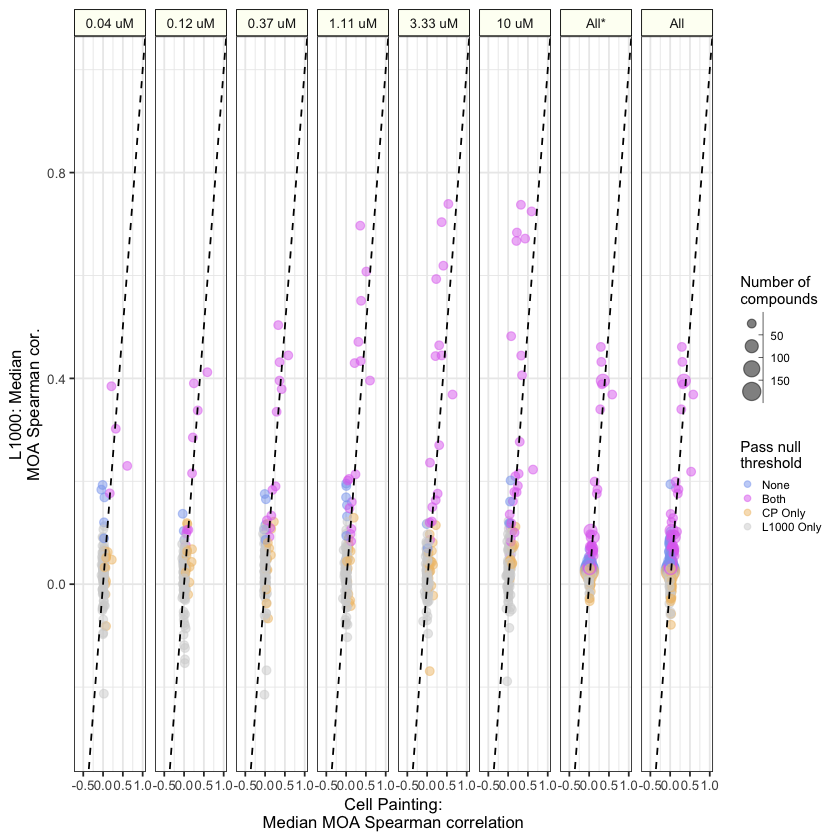

In [13]:
passing_colors <- unique(plot_ready_pm_df$moa_color_passing)
names(passing_colors) <- unique(plot_ready_pm_df$moa_color_passing)

passing_labels <- c("None", "L1000 Only", "CP Only", "Both")
names(passing_labels) <- unique(plot_ready_pm_df$moa_color_passing)

panel_b_gg <- (
    ggplot(plot_ready_pm_df, aes(x = `Cell Painting`, y = L1000))
    + geom_point(aes(size = avg_replicate_count, color = moa_color_passing), alpha = 0.5)
    + facet_grid("~dose")
    + figure_theme
    + scale_color_manual(
        "Pass null\nthreshold",
        values = passing_colors,
        labels = passing_labels
    )
    + scale_size_binned("Number of\ncompounds", range = c(0.5, 5))
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + xlim(c(-0.65, 1))
    + ylim(c(-0.3, 1))
    + xlab("Cell Painting:\nMedian MOA Spearman correlation")
    + ylab("L1000: Median\nMOA Spearman cor.")
    + theme(legend.key.size = unit(0.3, 'cm'))
)

panel_b_gg

## Panel C - MOA percent matching summary

In [14]:
summary_df <- pm_df %>%
    dplyr::select(moa, dose, assay, p_value) %>%
    reshape2::dcast(moa + dose ~ assay, value.var = "p_value") %>%
    dplyr::rename(
        "Cell_Painting_p_value" = `Cell Painting`,
        "L1000_p_value" = `L1000`
    ) %>%
    dplyr::left_join(
        pm_df %>%
        dplyr::select(moa, dose, assay, matching_score) %>%
        reshape2::dcast(moa + dose ~ assay, value.var = "matching_score") %>%
        dplyr::rename(
            "Cell_Painting_matching_score" = `Cell Painting`,
            "L1000_matching_score" = `L1000`
        ),
        by = c("moa", "dose")
    ) %>%
    dplyr::mutate(
        pass_cellpainting_thresh = Cell_Painting_p_value < p_val_alpha_thresh,
        pass_l1000_thresh = L1000_p_value < p_val_alpha_thresh
    ) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE))

head(summary_df, 3)

,moa,dose,Cell_Painting_p_value,L1000_p_value,Cell_Painting_matching_score,L1000_matching_score,pass_cellpainting_thresh,pass_l1000_thresh,pass_both
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
1,5 alpha reductase inhibitor,All,1.000,0.000,-0.018411522,0.08463029,FALSE,TRUE,FALSE
2,acat inhibitor,0.04 uM,0.513,0.900,0.004444607,-0.06868249,FALSE,FALSE,FALSE
3,acat inhibitor,0.12 uM,0.247,0.972,0.023240710,-0.12401277,FALSE,FALSE,FALSE


In [15]:
summary_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    ) %>%
    dplyr::arrange(dose)

dose,num_pass_cellpainting,num_pass_l1000,num_pass_both,unique_pass_cellpainting,unique_pass_l1000
<fct>,<int>,<int>,<int>,<int>,<int>
0.04 uM,20,9,4,16,5
0.12 uM,22,13,9,13,4
0.37 uM,25,20,13,12,7
1.11 uM,29,22,15,14,7
3.33 uM,36,19,16,20,3
10 uM,35,27,23,12,4
All*,58,64,34,24,30
All,93,106,50,43,56


In [16]:
pass_thresh_summary_moa_df <- summary_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    ) %>%
    dplyr::arrange(dose)

cell_painting_moa_rect <- pass_thresh_summary_moa_df %>%
    dplyr::select(dose, num_pass_cellpainting, unique_pass_cellpainting, num_pass_both) %>%
    dplyr::rename(c(ymax_bar = num_pass_cellpainting, unique_pass = unique_pass_cellpainting)) %>%
    dplyr::mutate(
        ymin_bar = 0,
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_moa_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_moa_df$dose))) * 2, 2),
        assay = "Cell Painting",
        label_text_y = 2,
        updated_ymin_bar = ymin_bar,
        updated_ymax_bar = ymax_bar - num_pass_both
    )

l1000_moa_rect <- pass_thresh_summary_moa_df %>%
    dplyr::mutate(ymax_bar = num_pass_cellpainting + unique_pass_l1000) %>%
    dplyr::select(dose, ymax_bar, unique_pass_cellpainting, unique_pass_l1000, num_pass_both) %>%
    dplyr::rename(c(ymin_bar = unique_pass_cellpainting, unique_pass = unique_pass_l1000)) %>%
    dplyr::mutate(
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_moa_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_moa_df$dose))) * 2, 2),
        assay = "L1000",
        label_text_y = ymax_bar - 1.5,
        updated_ymin_bar = ymin_bar + num_pass_both,
        updated_ymax_bar = ymax_bar
    )

both_moa_rect <- cell_painting_moa_rect %>%
    dplyr::select(dose, xmin_bar, xmax_bar, updated_ymin_bar, updated_ymax_bar) %>%
    dplyr::left_join(
        l1000_moa_rect %>%
        dplyr::select(dose, xmin_bar, xmax_bar, updated_ymin_bar, updated_ymax_bar),
        by = c("dose", "xmin_bar", "xmax_bar"),
        suffix = c("_cp", "_l1000")
    ) %>%
    dplyr::mutate(
        updated_ymin_bar = updated_ymax_bar_cp,
        updated_ymax_bar = updated_ymin_bar_l1000,
        assay = "Both"
    ) %>%
    dplyr::select(dose, xmin_bar, xmax_bar, assay, updated_ymin_bar, updated_ymax_bar)

full_moa_rect <- dplyr::bind_rows(cell_painting_moa_rect, l1000_moa_rect, both_moa_rect)

num_pass_both_moa_text <- full_moa_rect %>%
    dplyr::filter(assay == "Cell Painting") %>%
    dplyr::select(dose, xmin_bar, ymax_bar, num_pass_both) %>%
    dplyr::left_join(
        full_moa_rect %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(dose, ymin_bar) %>%
            dplyr::rename(c(ymin_l1000_bar = ymin_bar)),
        by = "dose"
    ) %>%
    dplyr::mutate(label_text_y = ymin_l1000_bar + num_pass_both / 2)

In [17]:
total_moas <- length(unique(summary_df$moa))
total_moas

[1] 211

In [18]:
moa_count_summary_per_dose <- summary_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(total_moa_count = length(unique(moa))) %>%
    dplyr::select(dose, total_moa_count) %>%
    dplyr::distinct()

moa_count_summary_per_dose

dose,total_moa_count
<fct>,<int>
All,211
0.04 uM,127
0.12 uM,127
0.37 uM,127
1.11 uM,127
3.33 uM,127
10 uM,127
All*,127


In [19]:
percentile_pass_moa_df <- pass_thresh_summary_moa_df %>%
    dplyr::left_join(moa_count_summary_per_dose, by = "dose") %>%
    dplyr::mutate(
        num_pass_total = unique_pass_l1000 + unique_pass_cellpainting + num_pass_both,
        num_pass_percentile = paste("Total:\n", round(num_pass_total / total_moa_count, 2) * 100, "%")
    ) %>%
    dplyr::select(dose, num_pass_total, num_pass_percentile)

percentile_pass_moa_df

dose,num_pass_total,num_pass_percentile
<fct>,<int>,<chr>
0.04 uM,25,Total: 20 %
0.12 uM,26,Total: 20 %
0.37 uM,32,Total: 25 %
1.11 uM,36,Total: 28 %
3.33 uM,39,Total: 31 %
10 uM,39,Total: 31 %
All*,88,Total: 69 %
All,149,Total: 71 %


In [20]:
# Prep legend order
full_moa_rect <- full_moa_rect %>%
    dplyr::left_join(percentile_pass_moa_df, by = "dose")

full_moa_rect$assay <- factor(full_moa_rect$assay, levels = c("L1000", "Both", "Cell Painting"))
full_moa_rect$dose <- factor(full_moa_rect$dose, levels = updated_dose_order)
num_pass_both_moa_text$dose <- factor(num_pass_both_moa_text$dose, levels = updated_dose_order)

Warning message:
“Removed 8 rows containing missing values (geom_text).”


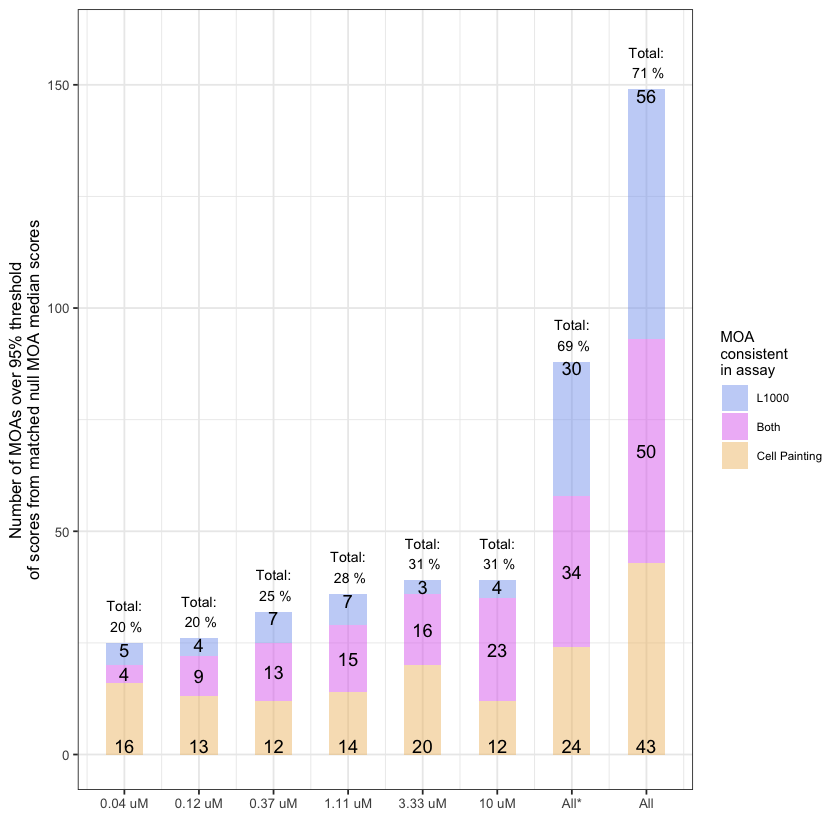

In [21]:
updated_assay_colors <- c(assay_colors, "Both" = "#DF74F0") 

panel_c_gg <- (
    ggplot(full_moa_rect)
    + geom_rect(
        aes(
            fill = assay,
            ymin = updated_ymin_bar,
            ymax = updated_ymax_bar,
            xmin = xmin_bar,
            xmax = xmax_bar
        ),
        alpha = 0.5
    )
    + geom_text(
        aes(
            x = xmin_bar + 0.5,
            y = label_text_y,
            label = unique_pass
        )
    )
    + geom_text(
        data = num_pass_both_moa_text,
        aes(
            x = xmin_bar + 0.5,
            y = label_text_y,
            label = num_pass_both
        )
    )
    # Select only L1000 below to not duplicate text
    + geom_text(
        data = full_moa_rect %>% dplyr::filter(assay == "L1000"),
        aes(
            x = xmin_bar + 0.5,
            y = ymax_bar + 6,
            label = num_pass_percentile
        ),
        size = 3
    )
    + scale_fill_manual("MOA\nconsistent\nin assay", values = updated_assay_colors)
    + theme_bw()
    + figure_theme
    + scale_x_continuous(
        labels = num_pass_both_moa_text$dose,
        breaks = seq(0.5, length(num_pass_both_moa_text$dose) * 2, 2),
    )
    + ylab("Number of MOAs over 95% threshold\nof scores from matched null MOA median scores")
    + xlab("")
    + ylim(0, max(full_moa_rect$num_pass_total, na.rm = TRUE) + 10)
)

panel_c_gg

## Panel D - MOA/Target Precision

In [22]:
# Load precision scores
precision_file <- file.path("..", "1.Data-exploration", "results", "moa_target_precision.tsv.gz")

precision_cols <- readr::cols(
  drug_impact = readr::col_character(),
  dose = readr::col_character(),
  avg_precision = readr::col_double(),
  impact_category = readr::col_character(),
  assay = readr::col_character()
)

# Load and process data for plotting
precision_df <- readr::read_tsv(precision_file, col_types = precision_cols) %>%
    reshape2::dcast(drug_impact+dose+impact_category+dose_comparison~assay, value.var = "avg_precision") %>%
    dplyr::arrange(desc(L1000))

# Separate the dose comparison and recode dose separately
same_dose_precision_df <- precision_df %>%
    dplyr::filter(dose_comparison == "same_dose")

same_dose_precision_df$dose <- as.numeric(paste(same_dose_precision_df$dose))
same_dose_precision_df$dose <- dplyr::recode_factor(same_dose_precision_df$dose, !!!dose_rename)

precision_df <- dplyr::bind_rows(
    same_dose_precision_df,
    precision_df %>%
        dplyr::filter(dose_comparison != "same_dose")
    ) %>%
    tidyr::drop_na()

precision_df$dose <- factor(precision_df$dose, levels = updated_dose_order)

impact_recode <- c("moa" = "Compound mechanism of action (MOA)", "target" = "Gene target")
precision_df$impact_category <- dplyr::recode_factor(precision_df$impact_category, !!!impact_recode)
precision_df$impact_category <- factor(precision_df$impact_category, levels = impact_recode)

print(dim(precision_df))
head(precision_df, 5)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] 5005    6


,drug_impact,dose,impact_category,dose_comparison,cell_painting,L1000
,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,HSP90AA1,0.04 uM,Gene target,same_dose,0.6666667,1
2,HSP90AA1,0.12 uM,Gene target,same_dose,0.2500000,1
3,inosine monophosphate dehydrogenase inhibitor,10 uM,Compound mechanism of action (MOA),same_dose,0.5833333,1
4,MAP3K1,10 uM,Gene target,same_dose,0.1428571,1
5,proteasome inhibitor,3.33 uM,Compound mechanism of action (MOA),same_dose,0.9093855,1


In [23]:
dose_colors <- c(
    "0.04 uM" = "#3B9AB2",
    "0.12 uM" = "#78B7C5",
    "0.37 uM" = "#EBCC2A",
    "1.11 uM" = "#E1AF00",
    "3.33 uM" = "#F21A00",
    "10 uM" = "#8B008B",
    "All" = "black"
)

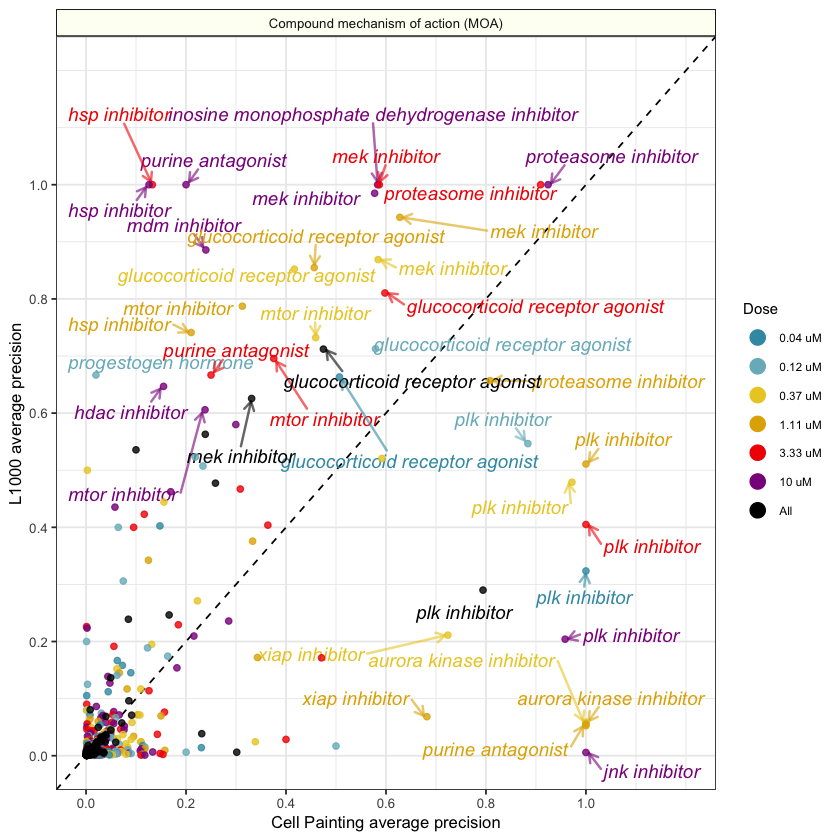

In [24]:
panel_d_df <- precision_df %>%
    dplyr::filter(impact_category == "Compound mechanism of action (MOA)")

color_logic <- (
    panel_d_df$L1000 > 0.60 |
    panel_d_df$cell_painting > 0.6
    )

panel_d_gg <- (
    ggplot(panel_d_df, aes(x = cell_painting, y = L1000, color = dose))
    + facet_grid("~impact_category")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + xlab("Cell Painting average precision")
    + ylab("L1000 average precision")
    + geom_text_repel(
        data = subset(panel_d_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.7,
        segment.alpha = 0.6,
        size = 4,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.25,
        aes(
            x = cell_painting,
            y = L1000,
            label = drug_impact,
        )
    )
    + geom_point(alpha = 0.8)
    + scale_color_manual(name = "Dose", values = dose_colors)
    + scale_x_continuous(breaks = seq(0, 1, 0.2), limits = c(0, 1.2))
    + scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(0, 1.2))
    + guides(
        color = guide_legend(override.aes = list(size = 4, alpha = 1)),
        text = guide_legend(override.aes = list(alpha = 0))
    )
)

panel_d_gg

## Panel E - Target

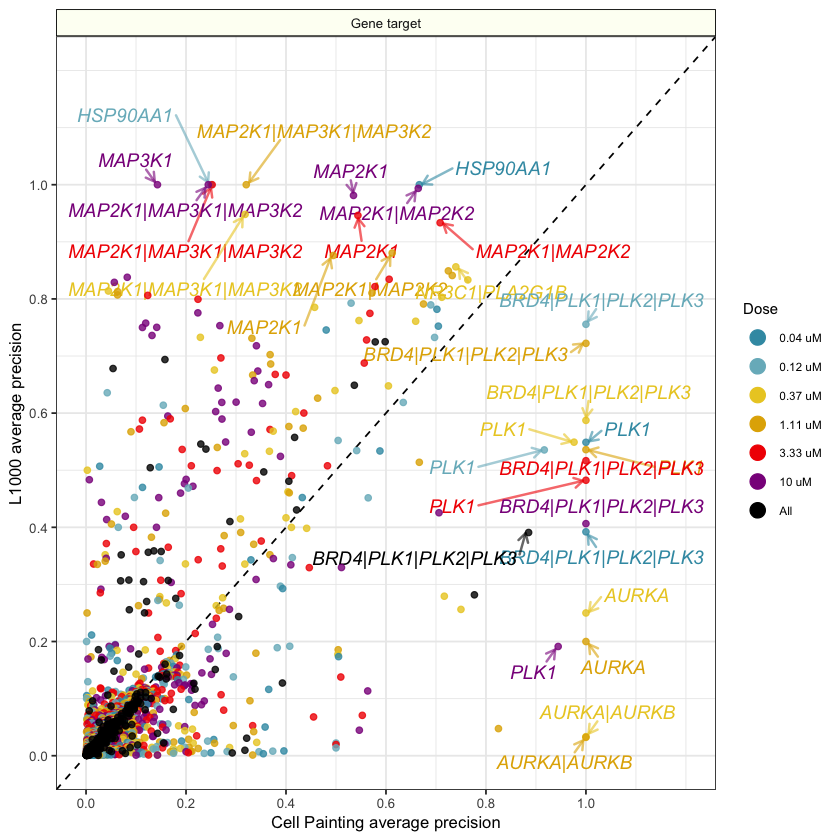

In [25]:
panel_e_df <- precision_df %>% dplyr::filter(impact_category == "Gene target")

color_logic <- (
    panel_e_df$L1000 > 0.85 |
    panel_e_df$cell_painting > 0.85
    )

panel_e_gg <- (
    ggplot(panel_e_df, aes(x = cell_painting, y = L1000, color = dose))
    + facet_grid("~impact_category")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + xlab("Cell Painting average precision")
    + ylab("L1000 average precision")
    + geom_text_repel(
        data = subset(panel_e_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.7,
        segment.alpha = 0.6,
        size = 4,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.25,
        aes(
            x = cell_painting,
            y = L1000,
            label = drug_impact,
        )
    )
    + geom_point(alpha = 0.8)
    + scale_color_manual(name = "Dose", values = dose_colors)
    + scale_x_continuous(breaks = seq(0, 1, 0.2), limits = c(0, 1.2))
    + scale_y_continuous(breaks = seq(0, 1, 0.2), limits = c(0, 1.2))
    + guides(
        color = guide_legend(override.aes = list(size = 4, alpha = 1)),
        text = guide_legend(override.aes = list(alpha = 0))
    )
)

panel_e_gg

## Compile figure 4

Warning message:
“Removed 8 rows containing missing values (geom_text).”
Warning message:
“Removed 8 rows containing missing values (geom_text).”
Warning message:
“Removed 8 rows containing missing values (geom_text).”


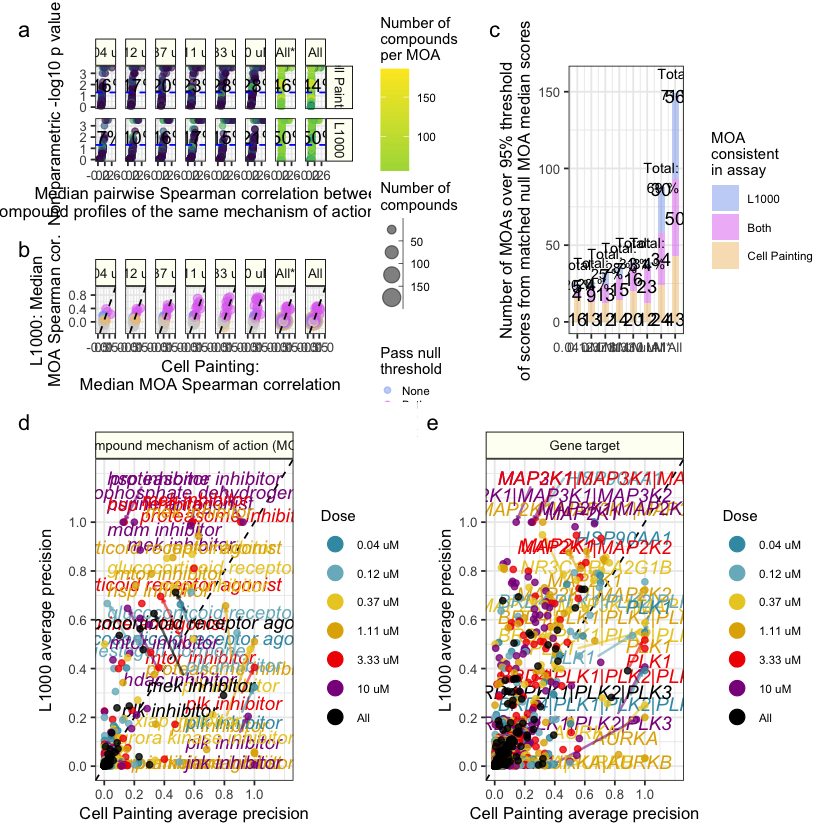

In [26]:
left_panel <- (panel_a_gg / panel_b_gg) + plot_layout(heights = c(2, 1))
top_panel <- (left_panel | panel_c_gg) + plot_layout(widths = c(2, 1))

bottom_panel <- (panel_d_gg | panel_e_gg)

figure_4_gg <- (
    top_panel / bottom_panel
    + plot_layout(heights = c(2, 2.4))
    + plot_annotation(tag_levels = "a")
)

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, figure_4_gg, width = 17.2, height = 14, dpi = 500)
}

figure_4_gg